# Shortest Path Agent
This notebook goes over how to use the output of the `NetworkEnvironment` to construct a `ShortestPathAgent`.   This agent holds true to it's name, ordering the environment to route packets to their target destination by following the shortest path.

## Install rl-routing
The following cell will install rl-routing if you are in colab.

In [1]:
if 'google.colab' in str(get_ipython()):
    !git clone https://github.com/lukewood/rl-routing && cd rl-routing && pip install .

If working on the repo I recommend working locally and installing the package with the following command:
```
!git clone https://github.com/lukewood/rl-routing && cd rl-routing && python setup.py develop
```

This allows you to make changes to your local repository.

# Graph Generation
The environment operates on a fully connected [NetworkX](https://networkx.org/) graph.  `nx.random_internet_as_graph` is a nice graph generator for this environmnet.

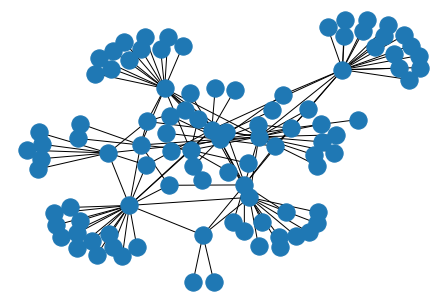

In [7]:
import networkx as nx
G=nx.random_internet_as_graph(100)
pos = nx.spring_layout(G)
nx.set_node_attributes(G, pos, "pos")
nx.draw(G)

# Shortest Path Agent
The environment returns a tuple, `(adj_matrix, wires, packets, routes)` from both `NetworkEnv.reset` and `NetworkEnv.render`.

The `routes` dict indexes on `(target,location)` and maps to `next_hop` respecting the shortest path algorithm.  We can use this to reconstruct the actions matrix, which is of shape `(nodes, nodes)`.  The actions matrix allows the agent to tell the environment where to route each packet.  The matrix is indexed by `(current_node, target_node)`.  -1 represents a no-op, other numbers tell the environment which node to route to.  Invalid values are ignored.

In [11]:
class ShortestPathAgent():
    def actions(self, observation):
        actions = -1*np.ones((len(G.nodes), len(G.nodes)), dtype=np.int32)
        adj_matrix, wires, packets, routes = observation
        # shortest path routes are returned as part of observation
        # as a baseline we construct an action based on this
        for f in routes.keys():
            for t in routes[f].keys():
                actions[f][t] = routes[f][t]
        return actions

# Putting it all together
The following shows how to put all of this together to "solve" the environment

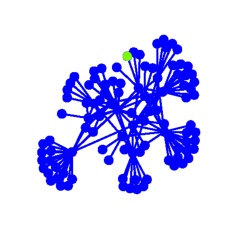

In [20]:
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
import time
from collections import defaultdict
from IPython.display import clear_output
import numpy as np

from rl_routing import NetworkEnv

def draw_output(img):
    plt.axis("off")
    plt.imshow(img)
    plt.show()

env = NetworkEnv(graph=G, fig=Figure(figsize=(6, 6)))
i = 100

agent = ShortestPathAgent()
observation = env.reset(initial_packets=1000)

total_rewards = []

for s in range(1000):

    actions = agent.actions(observation)
    # actions is a list of steps to be taken for each node
    # the packet with the highest value (earliest created) is sent based on step's input
    observation, reward, done, info = env.step(actions)
    
    img = env.render()
    draw_output(img)
    print("Step Reward", reward)
    print("Total Reward", env.completed_packets)
    print(f"Step {s}/1000")
    total_rewards.append(env.completed_packets)

    clear_output(wait=True)
    
    # Give a more efficient the agent to achieve more score
    if env.done():
        break

draw_output(env.render())

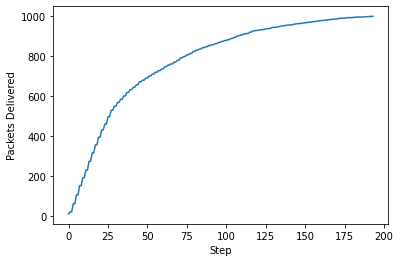

Solved in 194 steps


In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.lineplot(x=range(len(total_rewards)), y=total_rewards)
plt.xlabel("Step")
plt.ylabel("Packets Delivered")
plt.show()
print(f"Solved in {len(total_rewards)} steps")

# Next Steps
This is the "base case" to beat in this environment.  If you'd like to get involved and work together to use a simple statistical or RL approach to tackling this problem let me know!

I am also planning to implement "large files" which appear as a stream of 100 packets or so with matching sources and destinations.